In [4]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 573kB 21.3MB/s 
Populating the interactive namespace from numpy and matplotlib


#### A few imports before we get started

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### Mounting the google drive for later storage

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Morning Session 4 pt II: Transfer Learning

We will now explore one of the arguably most useful practises when dealing with small-datasets and wanting to create a powerful classifier - transfer learning.
Instead of training a network from randomly initialised weights, we start from a network with weights trained in a different domain and fine-tune it to a different source task. （现在，我们将探索在处理小数据集时最有用的实践之一，并希望创建一个强大的分类器——迁移学习。我们不是从随机初始化的权值来训练网络，而是从一个在不同领域训练权值的网络开始，并将其微调到不同的源任务。）

The basic principle behind is to leverage features learned on very large datasets and recycle them to perform tasks on smaller datasets.  （背后的基本原理是利用在非常大的数据集上学习到的特性，并回收它们来在较小的数据集上执行任务）

To be able to apply transfer learning effectively, the data distribution of the data that a very powerful model was trained on should follow a similar distribution as the smaller dataset that we are trying to apply transfer learning to.    （为了能够有效地应用迁移学习，一个非常强大的模型所训练的数据的数据分布应该与我们试图应用迁移学习的较小数据集的数据分布类似。）

For example:  
_We want to create a new classifier for cats and dogs given only a small set of say 100 training images of each category._

Very deep neural networks that have been trained on ImageNet or CIFAR have similar categories in their dataset, say horses and maybe cows and many more categories of natural images.  
The intuition is that since we've already learned a rich set of features on ImageNet, we can simply use a deep network as a feature extractor and only retrain the final layer of the networks to perform well at our task. So let's work our way towards transfer learning.

例如：
我们想要为猫和狗创建一个新的分类器，只给每个类别的一个小集合，比如100个训练图像。  在ImageNet或CIFAR上训练过的非常深层的神经网络在它们的数据集中有类似的类别，比如马，可能还有牛，还有更多自然图像的类别。 直觉告诉我们，既然我们已经在ImageNet上学习了一组丰富的特征，我们可以简单地使用一个深层网络作为特征提取器，并且只对网络的最后一层进行再训练，以更好地完成我们的任务。让我们来研究迁移学习。


In summary, transfer learning can be a powerful tool for:
- Preventing poor training from small-datasets
- Reducing training time for similar tasks

总之，迁移学习可以是一个强大的工具：
-  防止来自小数据集的糟糕训练
- 减少类似任务的训练时间

### Exercise 1: Inspecting the features of pre-trained deep neural networks

Pytorch provides users with a rich set of pre-trained neural network architectures. These have mostly been pre-trained on imagenet.   
[```torchvision.models```](https://pytorch.org/vision/stable/models.html) provides us with an interface to these pretrained deep neural networks.（Pytorch为用户提供了一套丰富的预训练神经网络架构。这些大多是在imagenet上预先训练的。 ```torchvision.models```为我们提供了与这些预先训练的深度神经网络的接口。）

- Load a pretrained [AlexNet](https://arxiv.org/abs/1404.5997) model from ```torchvision.models``` ([Source Code](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html) for AlexNet in Pytorch)
- Obtain the weight kernels of the first layer and display them (11x11 kernels shown as a matplotlib graph)（获得第一层的权重内核并显示它们(11x11个内核以matplotlib图显示)）
- Remembering the earlier exercise on traditional computer vision kernels and edge detection, how could these come in handy when learning on new data?


In [7]:
from torchvision import models

alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


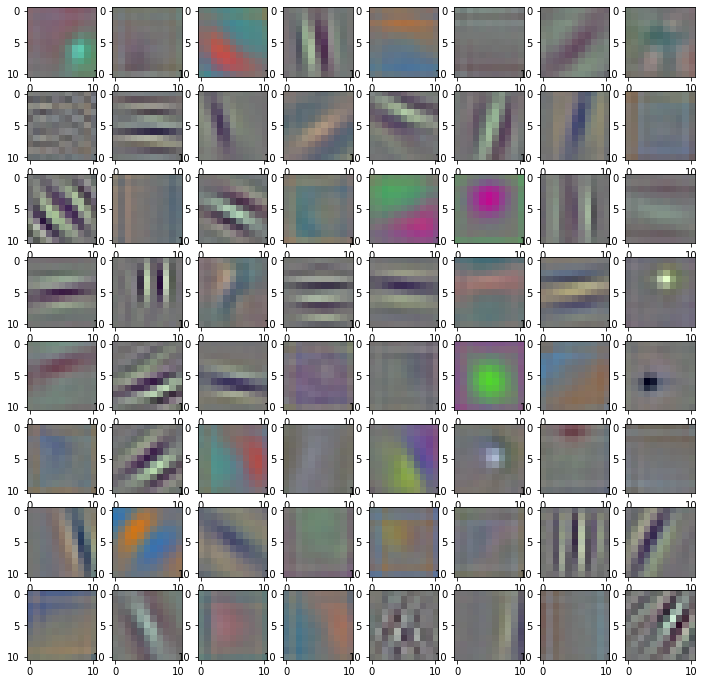

In [8]:
first_layer = alexnet.features[0]
print(first_layer)
weights = first_layer.weight.data

# Normalisation for plotting because imshow does like negative values(用于绘图的规范化，因为imshow喜欢负值)
min_w, max_w =  weights.min(), weights.max()
weights -= min_w
weights /= (max_w-min_w)

fig, axarr = plt.subplots(8, 8, figsize=(12, 12))
axarr = axarr.flatten()
for ax, kernel in zip(axarr, weights.numpy()):
  ax.imshow(np.swapaxes(kernel, 0, 2))

# 3 为输入通道数量，64为输出通道数量， 下面显示了该卷积层所有的权重参数

### Exercise 2: Transfer learning from ImageNet to Bees and Ants

In the previous exercise we've investigated what some features of a very deep pre-trained network look like and learned about transfer learning. Let's try it out! We will try to apply transfer learning to a small dataset containing images of bees and ants by training on top of networks previously trained on ImageNet.（在之前的练习中，我们研究了一个深度训练过的网络的一些特征，并学习了迁移学习。让我们试试吧!我们将尝试将迁移学习应用到包含蜜蜂和蚂蚁图像的小数据集，通过在ImageNet上训练之前的网络。）

ImageNet is arguably the most popular dataset for benchmarking classification models. It contains around 14 million annotated natural images spread over 22 thousand categories. Images are of size 3 x 224 x 224, with normalised means and stds of [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225]. In transfer learning is common practice to use the means and standard deviations of the data used for pretraining to normalise the new dataset. Note that the most popular networks (VGG, ResNet, AlexNet, etc..) have been design to take as input 3 x 224 x 224 images to accomodate for ImageNet.（ImageNet可以说是对分类模型进行基准测试最流行的数据集。它包含了大约1400万张注释过的自然图像，分布在2.2万个类别中。图像大小为3 x 224 x 224，标准化均值和标准偏差分别为[0.485,0.456,0.406]和[0.229,0.224,0.225]。在迁移学习中，常用的做法是使用预处理的数据的平均值和标准偏差来规范化新数据集。请注意，最流行的网络(VGG, ResNet, AlexNet等)已经被设计为输入3 x 224 x 224图像，以适应ImageNet）

<p style="text-align:center;"><img src="https://paperswithcode.com/media/datasets/ImageNet-0000000008-f2e87edd_Y0fT5zg.jpg" alt="drawing" width="500"/>
</p>

Adapted from [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

Perform the following tasks:

0. Adapt the training, validation and evaluation functions to the appropriate input size
1. [Download](https://download.pytorch.org/tutorial/hymenoptera_data.zip) the dataset into your current directory (you can do it manually, our use the code is provided below)
2. Investigate and visualize a few examples of the dataset. What pre-processing is required for this dataset?
3. Instantiate an untrained ResNet18 from [```torchvision.models```](https://pytorch.org/vision/stable/models.html) and make the necessary adaptations to our task in hands.
4. Train the newly initialised ResNet from scratch. What do you notice?
5. Now instantiate the pre-trained ReseNet18 by passing the argument ``pretrained=True`` and perform fine-tuning using a smaller learning rate
6. Use the provided ``set_parameters_requires_grad`` and ``get_params_to_update`` functions to repeat the step above freezing optimisation for all layers except the final classifying layer.
7. Finally, train a ResNet on MNIST from scratch and use those weights to repeat step 6. Does this work?

  



### Adapting training, validation and evaluation functions to our problem size

In [10]:
def train(model, optimizer, criterion, data_loader):
    # 和之前一样，训练一代，每一个batch更新一次梯度
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 224, 224))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 224, 224))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### Loading and Visualising the Data

In [9]:
!wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip -oq hymenoptera_data.zip

--2021-05-09 11:34:51--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 65.9.73.16, 65.9.73.85, 65.9.73.41, ...
Connecting to download.pytorch.org (download.pytorch.org)|65.9.73.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  30.3MB/s    in 1.5s    

2021-05-09 11:34:52 (30.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [11]:
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [12]:
from torchvision import datasets, transforms, models

transform = transforms.Compose([
        transforms.ToTensor(),  # #归一化到(0,1)，简单直接除以255
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=transform)

print(train_ds)
print(train_ds.classes)
print(train_ds.class_to_idx)
print(train_ds[0]) # an example of calling  __getitem__, which is what the dataloader does
print(train_ds.samples[0]) # get image path inside samples
print("\n\n")

# Get mean and std
tmp_loader = DataLoader(train_ds, batch_size=1, num_workers=0)
data = next(iter(tmp_loader))
mean = [torch.mean(data[0][0][i].flatten()).item() for i in range(3)] # 三层通道，分别计算每层的平均值
std = [torch.std(data[0][0][i].flatten()).item() for i in range(3)] # 三层通道，分别计算每层的平均值
print(mean, std)

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
['ants', 'bees']
{'ants': 0, 'bees': 1}
(tensor([[[0.3137, 0.3137, 0.3137,  ..., 0.3176, 0.3098, 0.2980],
         [0.3176, 0.3176, 0.3176,  ..., 0.3176, 0.3098, 0.2980],
         [0.3216, 0.3216, 0.3216,  ..., 0.3137, 0.3098, 0.3020],
         ...,
         [0.3412, 0.3412, 0.3373,  ..., 0.1725, 0.3725, 0.3529],
         [0.3412, 0.3412, 0.3373,  ..., 0.3294, 0.3529, 0.3294],
         [0.3412, 0.3412, 0.3373,  ..., 0.3098, 0.3059, 0.3294]],

        [[0.5922, 0.5922, 0.5922,  ..., 0.5961, 0.5882, 0.5765],
         [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5882, 0.5765],
         [0.6000, 0.6000, 0.6000,  ..., 0.5922, 0.5882, 0.5804],
         ...,
         [0.6275, 0.6275, 0.6235,  ..., 0.3608, 0.6196, 0.6157],
         [0.6275, 0.6275, 0.6235,  ..., 0.5765, 0.6275, 0.5961],
         [0.6275, 0.6275, 0.6235,  ...,

In [13]:
def show_batch(dataset, nr=4, nc=4):
  # 显示 25 个图像， 一个batch一个图像
  fig, axarr = plt.subplots(nr, nc, figsize=(10, 10))
  for i in range(nr):
      for j in range(nc):
          idx = random.randint(0, len(train_ds))
          sample, target = train_ds[idx]
          try:
            axarr[i][j].imshow(sample) # if PIL
          except:
            axarr[i][j].imshow(sample.permute(1,2,0)) # if tensor of shape CHW
          target_name = train_ds.classes[target]
          axarr[i][j].set_title("%s (%i)"%(target_name, target))

  fig.tight_layout(pad=1.5)
  plt.show()

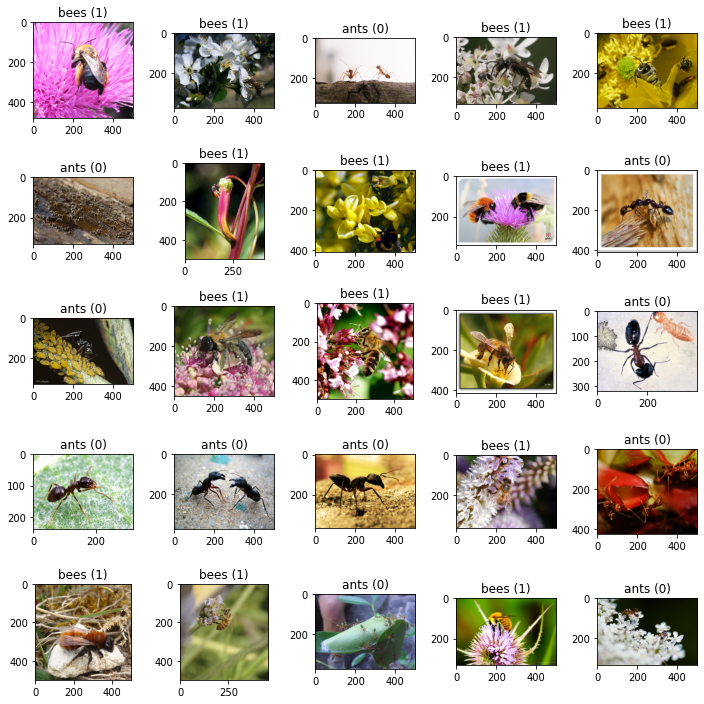

In [15]:
show_batch(train_ds, 5, 5)

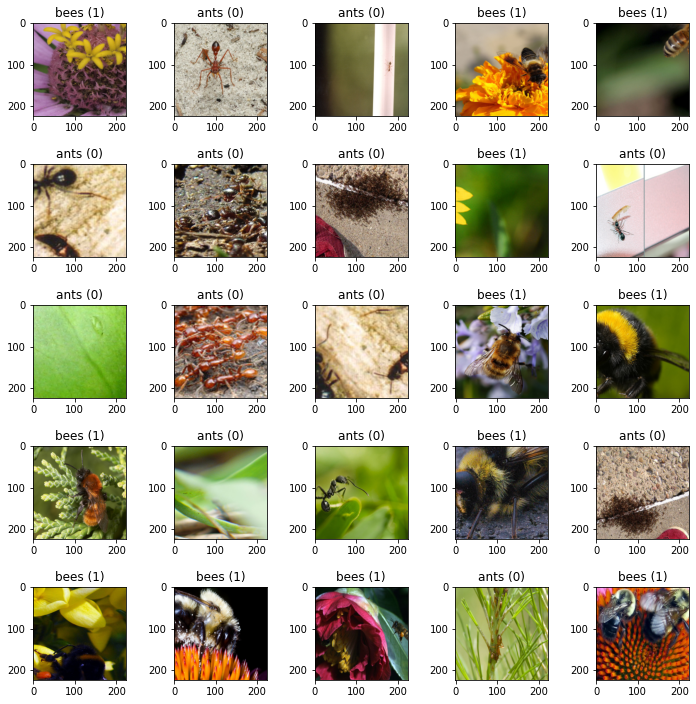

In [ ]:
# Fix image sizes with transforms
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

show_batch(train_ds, 5, 5)

In [16]:
# Finally add normalisation to transforms
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),  # 随机长宽比裁剪原始图片，最后将图片resize到设定好的size参数
        transforms.RandomHorizontalFlip(),  # 依据概率p对PIL图片进行水平翻转 参数： p- 概率，默认值为0.5
        transforms.ToTensor(),              # 将PIL Image或者 ndarray 转换为tensor，并且归一化至[0-1] 注意事项：归一化至[0-1]是直接除以255，若自己的ndarray数据尺度有变化，则需要自行修改。
        transforms.Normalize(mean, std),    # 对数据按通道进行标准化，即先减均值，再除以标准差，注意是 hwc
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),             # 重置图像分辨率
        transforms.CenterCrop(224),         # 依据给定的size从中心裁剪 参数： size- (sequence or int)，若为sequence,则为(h,w)，若为int，则(size,size)
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

# Create dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

### 1. Training a newly initialized Resnet18（训练一个新初始化的Resnet18）


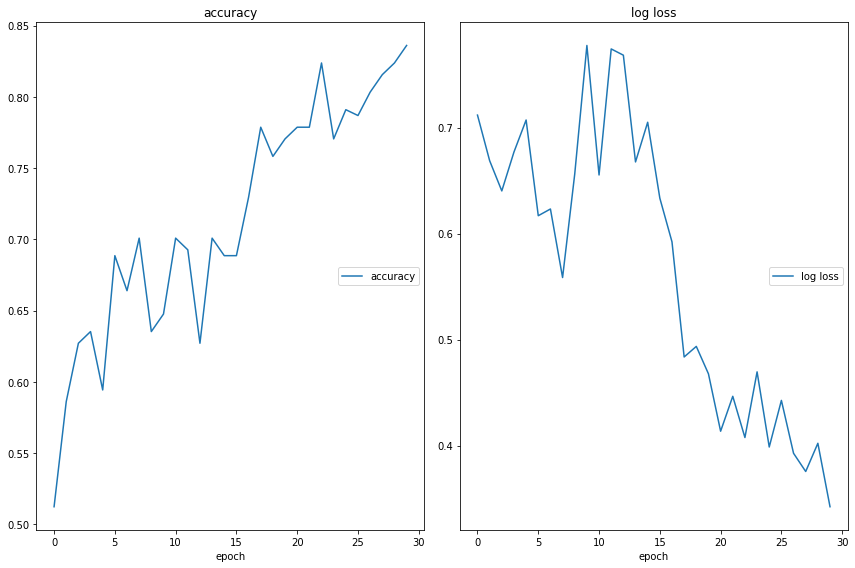

accuracy
	accuracy         	 (min:    0.512, max:    0.836, cur:    0.836)
log loss
	log loss         	 (min:    0.342, max:    0.777, cur:    0.342)
Avg. Test Loss: 0.839  Avg. Test Accuracy: 0.647



In [17]:
set_seed(seed)

model = models.resnet18().to(device)
print(model)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_baseline.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

Our model is not doing too well! The lack of data is taking a toll on our training and giving large generalisation error.（我们的模型不是很好!数据的缺乏对我们的训练造成了影响，并造成了很大的泛化错误。）

### 2. Finetuning a pre-trained Resenet（调整一个预先训练好的Resenet）

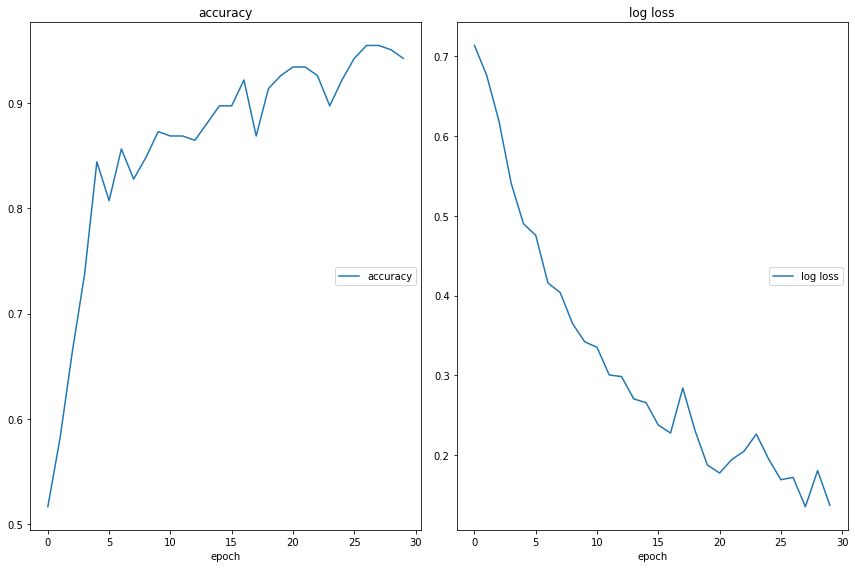

accuracy
	accuracy         	 (min:    0.516, max:    0.955, cur:    0.943)
log loss
	log loss         	 (min:    0.135, max:    0.714, cur:    0.137)
Avg. Test Loss: 0.201  Avg. Test Accuracy: 0.928



In [18]:
set_seed(seed)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, 2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1*lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_imagenet_finetune.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

### 3. Pre-trained Resenet as a Feature Extraction Tool（预先训练的Resenet作为特征提取工具）

In [19]:
def set_parameter_requires_grad(model, requires_grad=False):
    """https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html"""
    for param in model.parameters():
        param.requires_grad = requires_grad
    return None

def get_params_to_update(model):
    """ Returns list of model parameters that have required_grad=True"""
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

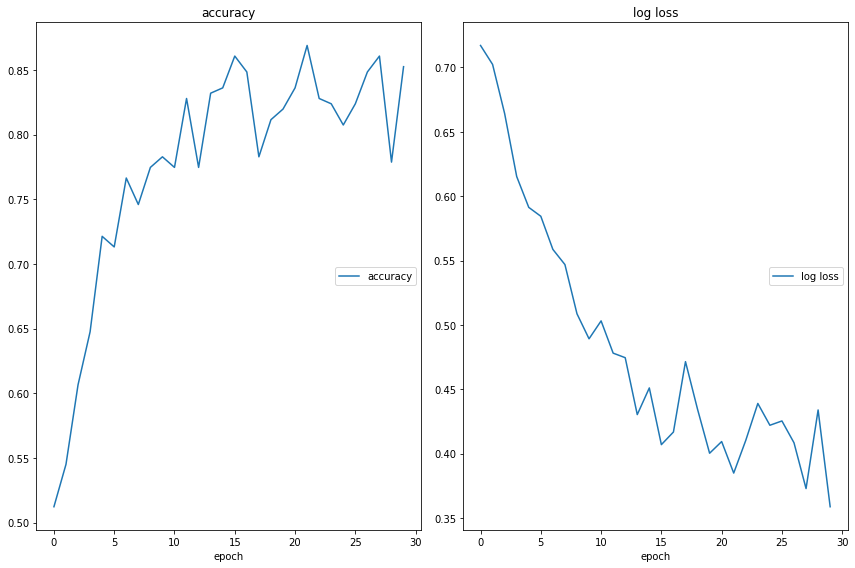

accuracy
	accuracy         	 (min:    0.512, max:    0.869, cur:    0.852)
log loss
	log loss         	 (min:    0.359, max:    0.717, cur:    0.359)
Avg. Test Loss: 0.330  Avg. Test Accuracy: 0.889



In [20]:
set_seed(seed)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = models.resnet18(pretrained=True).to(device)
print(model)
set_parameter_requires_grad(model, requires_grad=False) # 将预先训练的模型参数设置为不需要设置梯度更新
# 添加一个全连接层,只训练这个全连接层的权重
model.fc = nn.Linear(model.fc.in_features, 2).to(device)  # newly initialised layers automatically have requires_grad=True （新初始化的层自动有requires_grad=True）
print(model)

optimizer = torch.optim.SGD(get_params_to_update(model), lr=0.1*lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

model_save_name = 'resnet18_bees_and_ants_classifier_full_training_set_imagenet_feature_extract.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

If feature extraction can provide sufficiently good accuracy, we can significantly cut in traning time, particularly when the network is very deep and input images are large.（如果特征抽取可以提供足够好的准确性，我们可以显著减少训练时间，特别是当网络非常深，输入图像很大的时候。）

Fine tuning our model parts from the idea that the model starts from a point already close to the optimisation minimum; and that all we are doing is getting closer to that minimum. Feature extraction makes use of the exact features that are used to classified another dataset, only really tuning the final classifying layer.（从这个想法微调我们的模型部分：该模型从一个已经接近优化最小值的点开始;我们所做的就是接近最小值。特征提取利用用于分类另一个数据集的确切特征，只真正调整最终的分类层。）

<img src="https://pbs.twimg.com/media/Ev-f6AaU8AgMeRd.jpg" alt="drawing" width="600"/>

### 4. What if pretrained on MNIST instead?（如果在MNIST训练集上预训练）

#### 4.1 Training a Resnet on MNIST from scratch

In [21]:
train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  
        transforms.Lambda(lambda x: x.expand(3, 224, 224)),   # expand to 3 channels             
    ])
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.expand(3, 224, 224)),   # expand to 3 channels      
    ])

mnist_train = MNIST("./", download=True, train=True, transform=train_transform)
mnist_test = MNIST("./", download=True, train=False, transform=test_transform)

# print(mnist_train[0][0].shape)
# plt.imshow(mnist_train[0][0].permute(1,2,0))
# plt.show()

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, 10).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

feeling_lazy = True

if feeling_lazy:
  !gdown --id 1tOeWpr3jrKgtFu2qx1_4orLx_bwe-467
  path = F"./resnet18_mnist_trained.pt" 
  model.load_state_dict(torch.load(path))

else:
  ### ~ 7 min per epoch here ###
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()
      liveloss.update(logs)
      liveloss.draw()
      logs['val_' + 'log loss'] = 0.
      logs['val_' + 'accuracy'] = 0.

model_save_name = 'resnet18_mnist_classifier_full_training_set_baseline_.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)


test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

Downloading...
From: https://drive.google.com/uc?id=1tOeWpr3jrKgtFu2qx1_4orLx_bwe-467
To: /content/resnet18_mnist_trained.pt
44.8MB [00:00, 79.4MB/s]
Avg. Test Loss: 0.033  Avg. Test Accuracy: 0.991



### 4.2 Feature Extraction on the ResNet pretrained on MNIST


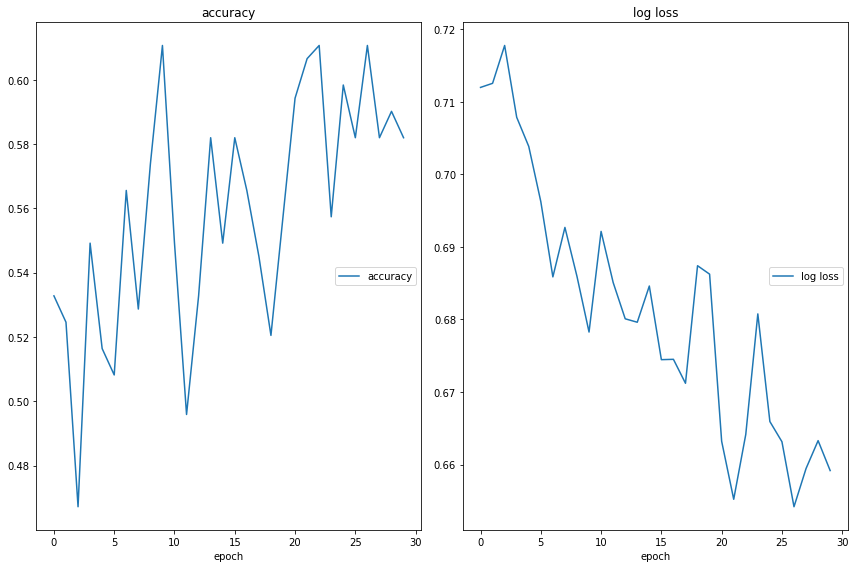

accuracy
	accuracy         	 (min:    0.467, max:    0.611, cur:    0.582)
log loss
	log loss         	 (min:    0.654, max:    0.718, cur:    0.659)
Avg. Test Loss: 0.657  Avg. Test Accuracy: 0.627



In [ ]:
set_seed(seed)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081]),
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1307, 0.1307, 0.1307], [0.229, 0.3081, 0.3081]),
    ])

train_ds = datasets.ImageFolder("./hymenoptera_data/train", transform=train_transform)
test_ds = datasets.ImageFolder("./hymenoptera_data/val", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, 10).to(device)
path = F"./resnet18_mnist_trained.pt" 
model.load_state_dict(torch.load(path))
model.fc = nn.Linear(model.fc.in_features, 2).to(device)

optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.1*lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

model_save_name = 'resnet18_bees_and_antes_classifier_full_training_set_mnist_transfer.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)


test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")



Seems that hand-written numbers and bees have very little to do with each other....

In [ ]:
def get_no_trainable_params(model):
  sum = 0
  for params in model.parameters():
    if params.requires_grad:
      sum += params.numel()
  return sum

print(get_no_trainable_params(models.resnet18()))
print(get_no_trainable_params(models.alexnet()))
print(get_no_trainable_params(models.resnet152()))
print(get_no_trainable_params(models.wide_resnet101_2()))

11689512
61100840
60192808
126886696
